In [11]:
import glob
import os
import emcee
#import triangle
import time
import numpy as np
from astropy.io import fits
from sklearn.decomposition import PCA
from sklearn import svm
from scipy.interpolate import interp1d
from scipy import convolve
from scipy import optimize as opt

import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

In [12]:
# HDU_list = fits.open("spectra/spec-0387-51791-0005.fits")


all_flux = []
all_lambda = []
SN_array = np.array([])
ra_array = []
dec_array = []

directory = '/Users/MichaelFoley/WDSpectralFitting/notebooks/data/test/'
# Kleinman DA Spectra
for filename in glob.glob(directory+"*.fits"):
    data = fits.getdata(filename, 1)
    
    temp = fits.getdata(filename, 2)
    SN_array = np.append(SN_array, temp["SN_MEDIAN_ALL"])
    
    all_flux.append(data['flux'])
    all_lambda.append(10 ** data['loglam'])
    ra_array = np.append(ra_array, temp['PLUG_RA'])
    dec_array = np.append(dec_array, temp['PLUG_DEC'])


# Load Kleinman spectra
datafile = os.path.abspath("./kleinman_masses.dat")
names = ["RA","Dec","M_wd","M_wd_err"]
kleinman_masses = np.genfromtxt(datafile, dtype=None, usecols=range(len(names)), names=names)
    

# ELM Spectra
for filename in glob.glob("spectra_ELM/*.fits"):
    data = fits.getdata(filename, 1)
    
    temp = fits.getdata(filename, 2)
    SN_array = np.append(SN_array, temp["SN_MEDIAN_ALL"])
    
    all_flux.append(data['flux'])
    all_lambda.append(10 ** data['loglam'])
    ra_array = np.append(ra_array, temp['PLUG_RA'])
    dec_array = np.append(dec_array, temp['PLUG_DEC'])

    

#    break
    

error: [Errno 24] Too many open files

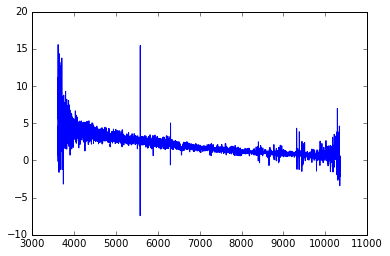

139.99489 47.094364


In [4]:
# Check a spectrum to make sure everything looks good
plt.plot(all_lambda[3],all_flux[3])
plt.show()

print ra_array[3], dec_array[3]



In [5]:
# Let's find the highest S/N spectrum

index_best = np.argmax(SN_array)

print index_best

1


### Now let's see if we can fit the spectrum to a model with several components:


1. T$_{\rm eff}$
2. Shift in $x$ to get the middle of the line profiles
3. Scale parameter for each Balmer line
4. Multiplicative factor for each Balmer line
5. Overall scale factor to account for brightness of overall spectrum

There are therefore 15 parameters overall. This is because we want to fit 6 hydrogen Balmer lines (H$\alpha$ to H8), and each line has two parameters.

### Let's create our model

In [6]:
# Our model has a temperature effect, then absorption features on top of the model


# Constants
h_planck = 4.136e-15 # in eV*s 
c_light = 2.998e10   # in cgs
k_boltz = 8.617e-5   # in eV/K


# Balmer line centers (in cgs):
lambda_balmer = 1.0e-8 * np.array([6563., 4861., 4341., 4102., 3970., 3889.])

# Lorentz distribution:
def lorentz(C_coeff, x_center, gamma, x):
    return C_coeff / (np.pi * gamma * (1.0 + ((x-x_center)/gamma)**2))


# Calculate model spectrum
def get_model_flux(p, lamb):
    balmer_C = np.zeros(6)
#    balmer_gamma = np.zeros(6)

    
    A_coeff, l_shift, Teff, balmer_gamma, balmer_C_1, balmer_C_2, balmer_C_3,balmer_C_4, balmer_C_5, balmer_C_6 = p
#    A_coeff, l_shift, Teff, balmer_gamma_1, balmer_gamma_2, balmer_gamma_3, balmer_gamma_4, balmer_gamma_5, balmer_gamma_6, balmer_C_1, balmer_C_2, balmer_C_3,balmer_C_4, balmer_C_5, balmer_C_6 = p
#    balmer_gamma = np.array([balmer_gamma_1, balmer_gamma_2, balmer_gamma_3, balmer_gamma_4, balmer_gamma_5, balmer_gamma_6])
    balmer_C = np.array([balmer_C_1, balmer_C_2, balmer_C_3, balmer_C_4, balmer_C_5, balmer_C_6])
    
    flux = np.array([])
    
    lamb_p = (lamb - l_shift) * 1.0e-8
    flux = A_coeff * 2.0 * h_planck * c_light*c_light / (lamb_p*lamb_p*lamb_p*lamb_p*lamb_p) / (np.exp(h_planck * c_light / (k_boltz * Teff * lamb_p)) - 1.)

    for i in np.arange(6):
        flux = flux * (1.0 - 1.0e-8 * lorentz(balmer_C[i], lambda_balmer[i], balmer_gamma, lamb_p))

    return flux


# Likelihood function
def ln_likelihood(p, lamb, flux, snr):
    
    model_flux = get_model_flux(p, lamb)
      
    # Standard deviation comes from the flux and S-N ratio
#    sd = flux / snr
    sd = 1.0 / snr
        
    diff = -(flux - model_flux)*(flux - model_flux) / (2.0 * sd*sd)
    
    return diff

# Prior function
def ln_prior(p):
    balmer_C = np.zeros(6)
#    balmer_gamma = np.zeros(6)
    
    A_coeff, l_shift, Teff, balmer_gamma, balmer_C_1, balmer_C_2, balmer_C_3,balmer_C_4, balmer_C_5, balmer_C_6 = p
#    A_coeff, l_shift, Teff, balmer_gamma_1, balmer_gamma_2, balmer_gamma_3, balmer_gamma_4, balmer_gamma_5, balmer_gamma_6, balmer_C_1, balmer_C_2, balmer_C_3,balmer_C_4, balmer_C_5, balmer_C_6 = p
#    balmer_gamma = np.array([balmer_gamma_1, balmer_gamma_2, balmer_gamma_3, balmer_gamma_4, balmer_gamma_5, balmer_gamma_6])
    balmer_C = np.array([balmer_C_1, balmer_C_2, balmer_C_3, balmer_C_4, balmer_C_5, balmer_C_6])

    
    if np.any(balmer_C < 0.0):
        return -np.inf
    
    # limits from expectation on Lorentz features
    if balmer_gamma < 1.0e-8:
#    if np.any(balmer_gamma < 1.0e-8):
        return -np.inf
    if balmer_gamma > 5.0e-6:
#    if np.any(balmer_gamma > 5.0e-6):
        return -np.inf
    
    return 0.0
    

# Posterior function calls the likelihood function
def ln_posterior(p, lamb, flux, snr):
    
    lp = ln_prior(p)
    ll = ln_likelihood(p, lamb, flux, snr)
    
    return -(lp + ll.sum())
#    return lp + ll.sum()


def ln_posterior_first(p, lamb, flux, snr):
    p_first = np.zeros(10)
    p_first[0] = p[0] # A_coeff
    p_first[1] = 1.0 # l_shift
    p_first[2] = p[1] # Teff
    p_first[3] = 1.0e-7 # balmer_gamma(_1)
#    p_first[4] = 1.0e-7 # balmer_gamma_2
#    p_first[5] = 1.0e-7 # balmer_gamma_3
#    p_first[6] = 1.0e-7 # balmer_gamma_4
#    p_first[7] = 1.0e-7 # balmer_gamma_5
#    p_first[8] = 1.0e-7 # balmer_gamma_6

    
    lp = ln_prior(p_first)
    ll = ln_likelihood(p_first, lamb, flux, snr)
    
#    return -ll.sum()
#    return lp + ll.sum()
    return -(lp + ll.sum())

### Model initial conditions

In [7]:
def run_first_inference(lamb, flux, snr, nwalkers=32, nburn=200, nsteps=1000):
    
    ndim = 2
    
    # Initial conditions for walkers
    Teff = 10000.0   # initial T_eff = 10,000 K
    A_coeff = 1.0e-26 # initial brightness coeff

    p0 = np.zeros((nwalkers,ndim))
    p0[:,0] = np.random.normal(A_coeff, 0.1*A_coeff, size=nwalkers)
    p0[:,1] = np.random.normal(Teff, 0.1*Teff, size=nwalkers)

    
    args = (lamb, flux, snr)
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=ndim, lnpostfn=ln_posterior_first, args=args)

    # burn-in
    sampler.run_mcmc(p0, N=nburn)
    pos,prob,state = sampler.run_mcmc(p0, N=nburn)

    # throw out burn-in samples
    sampler.reset() 
    pos,prob,state = sampler.run_mcmc(pos, N=nsteps)

    return sampler



In [8]:
def run_inference(p, lamb, flux, snr, nwalkers=32, nburn=200, nsteps=1000):

    n_lines = 6
#    ndim = 5
#    ndim = 2*n_lines+3
    ndim = n_lines+4 
            
    # Initial conditions for walkers
    Teff = p[1]   # initial T_eff = 10,000 K
    l_shift = 1.0    # initial wavelength shift
    A_coeff = p[0] # initial brightness coeff
    balmer_gamma = 2.0e-7 # Balmer line scaling factor
#    balmer_gamma = 2.0e-7 * np.ones(n_lines) # Balmer line scaling factor
    balmer_C = 30.0 * np.ones(n_lines)  # Individual Balmer line strengths

    p_i = np.array([A_coeff, l_shift, Teff])
    p_i = np.append(p_i,balmer_gamma)
    p_i = np.append(p_i,balmer_C)
    
    p0 = np.zeros((nwalkers,ndim))
    for i in np.arange(ndim):
        p0[:,i] = np.random.normal(p_i[i], 0.1*p_i[i], size=nwalkers)

        
        
    args = (lamb, flux, snr)
    sampler = emcee.EnsembleSampler(nwalkers=nwalkers, dim=ndim, lnpostfn=ln_posterior, args=args)

    
    # burn-in
    sampler.run_mcmc(p0, N=nburn)
    pos,prob,state = sampler.run_mcmc(p0, N=nburn)

    # throw out burn-in samples
    sampler.reset() 
    pos,prob,state = sampler.run_mcmc(pos, N=nsteps)

    return sampler
    


In [9]:
start_time = time.time()

classify_t_eff = np.array([])
classify_gamma = np.array([])
classify_C1 = np.array([])
classify_C2 = np.array([])
classify_C3 = np.array([])
classify_C4 = np.array([])
classify_C5 = np.array([])
classify_C6 = np.array([])
classify_mass = np.array([])
classify_mass_err = np.array([])
classify_snr = np.array([])


for index in np.arange(len(all_lambda)):

    lamb_temp1 = all_lambda[index][all_lambda[index]<7000.0]
    flux_temp1 = all_flux[index][all_lambda[index]<7000.0]
    lamb_temp2 = lamb_temp1[lamb_temp1>3865.0]
    flux_temp2 = flux_temp1[lamb_temp1>3865.0]

    lamb = lamb_temp2[np.where(flux_temp2>0)]
    flux = flux_temp2[np.where(flux_temp2>0)]

    snr = SN_array[index]    

    # Initial guess
    Teff = 10000.0   # initial T_eff = 10,000 K
    A_coeff = 1.0e-26 # initial brightness coeff
    p0 = np.array([A_coeff, Teff])
    res0 = opt.minimize(ln_posterior_first, p0, args=(lamb, flux, snr), method='Nelder-Mead', tol=1.0e-2)
        
    p = np.array([res0.x[0], 1.0, res0.x[1], 2.0e-7])
    balmer_C = 30.0 * np.ones(6)    
    p = np.append(p, balmer_C)
    
    res = opt.minimize(ln_posterior, p, args=(lamb, flux, snr), method='Nelder-Mead', tol=1.0)
    p_out = res.x
    
    
    for i in np.arange(len(kleinman_masses)):
        if abs(kleinman_masses["RA"][i] - ra_array[index]) < 0.01 and abs(kleinman_masses["Dec"][i] - dec_array[index]) < 0.01:
            print index, kleinman_masses["M_wd"][i]
            
            classify_t_eff = np.append(classify_t_eff, p_out[2])
            classify_gamma = np.append(classify_gamma, p_out[3])
            classify_C1 = np.append(classify_C1, p_out[4])
            classify_C2 = np.append(classify_C2, p_out[5])
            classify_C3 = np.append(classify_C3, p_out[6])
            classify_C4 = np.append(classify_C4, p_out[7])
            classify_C5 = np.append(classify_C5, p_out[8])
            classify_C6 = np.append(classify_C6, p_out[9])
            classify_snr = np.append(classify_snr, snr)
            
            classify_mass = np.append(classify_mass, kleinman_masses["M_wd"][i])
            classify_mass_err = np.append(classify_mass_err, kleinman_masses["M_wd_err"][i])        

            
print "Elapsed time = ", time.time() - start_time

Elapsed time =  1.2760720253


In [10]:
params = np.zeros((len(classify_gamma),8))

params[:,0] = classify_t_eff
params[:,1] = classify_gamma
params[:,2] = classify_C1
params[:,3] = classify_C2
params[:,4] = classify_C3
params[:,5] = classify_C4
params[:,6] = classify_C5
params[:,7] = classify_C6


types = np.zeros(len(classify_gamma))
types[np.where(classify_mass < 0.45)] = 1.0


clf = svm.SVC()
clf.fit(params, types)

ValueError: Found array with 0 sample(s) (shape=(0, 8)) while a minimum of 1 is required.

In [653]:

index = 7
print classify_mass[index], clf.predict(params[index])

0.547 [ 0.]


0.688 0.070


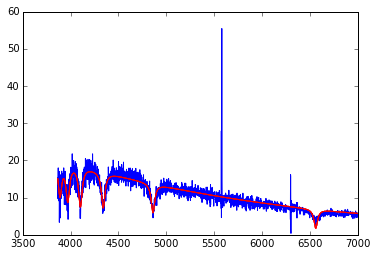

In [509]:
ndim = 10

plt.plot(lamb, flux)

flux_out = get_model_flux(p, lamb)
plt.plot(lamb, flux_out, color='r', alpha=0.2)
    

plt.show()